## Prerequisites

In [1]:
import os, sys

import numpy as np
import tqdm
import torch

/home/marco/miniconda3/envs/nuans_minihw2/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Important paths for the notebook:

In [2]:
datasets_root_path = './temp_files/'
srl_dataset_path = os.path.join(datasets_root_path, 'maven_nounited_srl')
checkpoints_dir_path = './checkpoints/'
model_dir_path = os.path.join(checkpoints_dir_path, 'other')

srl_dataset_dict_paths = {}
for lang in os.listdir(srl_dataset_path):
    dataset_lang_path = os.path.join(srl_dataset_path, lang)
    if os.path.isdir(dataset_lang_path):
        srl_dataset_dict_paths[lang] = {}
        for d_type in os.listdir(dataset_lang_path):
            d_name = d_type.split('.')[0]
            srl_dataset_dict_paths[lang][d_name] = os.path.join(dataset_lang_path, d_type)

In [3]:
%load_ext autoreload
%autoreload 2

device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

Setting the seed for reproducibility:

In [4]:
SEED = 28

# random.seed(SEED) # not used
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [5]:
global_params = np.load(os.path.join(checkpoints_dir_path, 'models_nounited_maven', 'global_params.npy'), allow_pickle=True).tolist()

getting the nominal synsets with hypernyms that were explored via SynsetExplorer

In [6]:
import json

va_frame_info = {}
with open('./va_resources/VerbAtlas-1.1.0/VerbAtlas-1.1.0/VA_frame_info.tsv') as file:
    for line in file:
        l = line.strip('\n').split('\t')
        if len(l) > 2: # l[0] = va, l[1] = name, l[2] = info
            va_frame_info[l[1].upper()] = l[2]

explored_nominal_graph_path = './va_resources/explored_nominal_graph.json'
with open(explored_nominal_graph_path, 'r') as json_file:
    explored_nominal_graph = json.load(json_file)

poss_cand_solved_statistically_path = './va_resources/poss_cand_solved_statistically.json'
with open(poss_cand_solved_statistically_path, 'r') as json_file:
    poss_cand_solved_statistically = json.load(json_file)

getting only the ones directly connected with a verbal synset of VerbAtlas

In [7]:
explored_nominal_graph_drf = {k:v for k,v in explored_nominal_graph.items() if v['is_drf'] == True}

getting only the ambiguous ones:

In [8]:
explored_nominal_graph_drf_ambiguous = {k:v for k,v in explored_nominal_graph_drf.items() if len(v['frames']) > 1}

getting only the unambiguous ones:

In [9]:
explored_nominal_graph_drf_unambiguous = {k:v for k,v in explored_nominal_graph_drf.items() if len(v['frames']) == 1}

# Dataset

In [38]:
from torch.utils.data import Dataset

class NCDataset(Dataset):
    def __init__(self, data_dict, ambiguous = False):
        self.data = []
        for syn, e in data_dict.items():
            self.data.append({
                'synset': syn,
                'word': syn.split('.')[0],
                'definition': e['definition'],
                'label': e['frames'][0] if not ambiguous else e['frames'],
            })

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

    @staticmethod
    def create_collate_fn():
        def collate_fn(batch):
            batch_formatted = {
                'word':[sample['word'] for sample in batch], 
                'definition':[sample['definition'] for sample in batch], 
                'label':[sample['label'] for sample in batch]
            }
            return batch_formatted

In [11]:
split_ratio = 0.8
dataset_dim = len(explored_nominal_graph_drf_unambiguous)
explored_nominal_graph_drf_unambiguous_train = {}
explored_nominal_graph_drf_unambiguous_valid = {}
for k,v in explored_nominal_graph_drf_unambiguous.items():
    if len(explored_nominal_graph_drf_unambiguous_train) < dataset_dim*0.8:
        explored_nominal_graph_drf_unambiguous_train[k] = v
    else:
        explored_nominal_graph_drf_unambiguous_valid[k] = v

In [12]:
nc_train_dataset = NCDataset(explored_nominal_graph_drf_unambiguous_train, ambiguous = False)
nc_valid_dataset = NCDataset(explored_nominal_graph_drf_unambiguous_valid, ambiguous = False)

In [13]:
from torch.utils.data import DataLoader
ni_train_dataloader = DataLoader(
    nc_train_dataset, 
    batch_size=global_params['batch_size'], 
    collate_fn=NCDataset.create_collate_fn(),
    shuffle=True)
ni_valid_dataloader = DataLoader(
    nc_valid_dataset, 
    batch_size=global_params['batch_size'], 
    collate_fn=NCDataset.create_collate_fn(),
    shuffle=False)

In [14]:
loss_function = torch.nn.CrossEntropyLoss()

In [15]:
from code_files.models.nominal_event_classifier import NEClassifier
from code_files.utils.utils_functions import print_summary
import torch.optim as optim

In [16]:
model_nc = NEClassifier(
    loss_fn = loss_function,
    hparams = global_params,
    fine_tune_transformer = True
)

Some weights of the model checkpoint at xlm-roberta-base were not used when initializing XLMRobertaModel: ['lm_head.layer_norm.weight', 'lm_head.decoder.weight', 'lm_head.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing XLMRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [17]:
for batch_sample in ni_valid_dataloader:
    break

In [34]:
ssml = 0
print(
    batch_sample['word'][ssml], '|', 
    batch_sample['definition'][ssml], '|', 
    batch_sample['label'][ssml])
with torch.no_grad():
    batch_predict = model_nc.forward(batch_sample['definition'], batch_sample['word'])
    batch_predict_processed = model_nc.process_predictions(batch_predict)
    batch_predict_indices = model_nc.get_indices(batch_predict)
    print(batch_predict.shape)
    print(batch_predict_processed[ssml])
    print(batch_predict_indices[ssml])

damper | a depressing restraint | WEAKEN
torch.Size([32, 433])
STOP
tensor(384, device='cuda:0')


In [19]:
optimizer_pid = optim.SGD(model_nc.parameters(), lr=0.0016, momentum=0.9) 

In [20]:
print_summary(model_nc, short=True)

parameters: 278,376,625
trainable parameters: 278,376,625
non-trainable parameters: 0


In [21]:
history = {}

In [22]:
from code_files.utils.Trainer_nec import Trainer_nec

trainer_nc = Trainer_nec()

history = trainer_nc.train(
    model_nc, optimizer_pid, ni_train_dataloader, ni_valid_dataloader,
    epochs=100, device=device,
    save_best=True, 
    min_score=0.8,
    save_path_name=os.path.join(model_dir_path, f'nominal_class_model.pth'),
    saved_history=history
)

Epoch   0 => avg_loss: 0.760538
# Validation loss => 0.768990 | f1-score: event_class = 0.072142 #
----- Best value obtained, saving model -----
Epoch   1 => avg_loss: 0.734253
# Validation loss => 0.780948 | f1-score: event_class = 0.072142 #
Epoch   2 => avg_loss: 0.715782
# Validation loss => 0.795489 | f1-score: event_class = 0.072142 #
Epoch   3 => avg_loss: 0.705687
# Validation loss => 0.808267 | f1-score: event_class = 0.072277 #
Epoch   4 => avg_loss: 0.699332
# Validation loss => 0.820992 | f1-score: event_class = 0.071719 #
Epoch   5 => avg_loss: 0.694903
# Validation loss => 0.830615 | f1-score: event_class = 0.072142 #
Epoch   6 => avg_loss: 0.689689
# Validation loss => 0.841612 | f1-score: event_class = 0.072142 #
Epoch   7 => avg_loss: 0.686696
# Validation loss => 0.850622 | f1-score: event_class = 0.072142 #
Epoch   8 => avg_loss: 0.687930
# Validation loss => 0.856815 | f1-score: event_class = 0.067282 #
Epoch   9 => avg_loss: 0.683793
# Validation loss => 0.860484 |

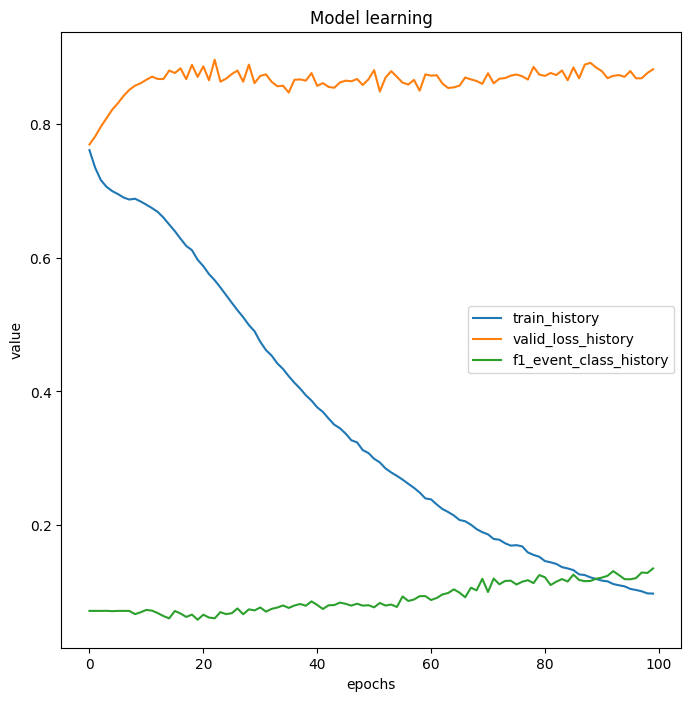

In [23]:
trainer_nc.display_history(history)

## Getting results

In [48]:
va_frame_info = {}
with open('./va_resources/VerbAtlas-1.1.0/VerbAtlas-1.1.0/VA_frame_info.tsv') as file:
    for line in file:
        l = line.strip('\n').split('\t')
        if len(l) > 2: # l[0] = va, l[1] = name, l[2] = info
            va_frame_info[l[1].upper()] = l[2]

In [49]:
nc_all_dataset = NCDataset(explored_nominal_graph_drf, ambiguous = False)

In [55]:
results = {}
model_nc.eval()
for e in nc_all_dataset:
    with torch.no_grad():
        predict = model_nc.predict([e['definition']], [e['word']])[0]
        results[e['synset']] = [e['definition'], predict, va_frame_info[predict]]

In [56]:
with open(os.path.join('./temp_files/synsets_solved_with_nc_model.tsv'), 'w') as tsvfile:
    for synset, values in results.items():
        row = synset + '\t' + '\t'.join(values)
        print(row, file=tsvfile)

In [59]:
in_frames = 0
for syn, values in results.items():
    if values[1] in explored_nominal_graph_drf[syn]['frames']:
        in_frames += 1
print(in_frames, '/', len(results), '=', in_frames/len(results))

2582 / 3974 = 0.649723200805234


In [60]:
in_frames = 0
for syn, values in results.items():
    if values[1] not in explored_nominal_graph_drf[syn]['frames']:
        print(syn, '|', values[0], '|', values[1], '|', values[2])
        print(explored_nominal_graph_drf[syn]['frames'])
        print('----------------------------')

act.n.02 | something that people do or cause to happen | RISK | An agent RISKS a theme for a goal (+attribute)
['INCITE_INDUCE', 'CARRY-OUT-ACTION', 'AROUSE_WAKE_ENLIVEN']
----------------------------
continuance.n.01 | the act of continuing an activity without interruption | STOP | An agent STOPS a theme or a topic in a location for an extent or from a source to a goal using an instrument (+attribute)
['GO-FORWARD', 'CONTINUE', 'SPEAK']
----------------------------
adoption.n.01 | the act of accepting with approval; favorable reception | AUTHORIZE_ADMIT | An agent AUTHORIZES-ADMITS a beneficiary to a theme for a purpose (+idiom)
['FOLLOW_SUPPORT_SPONSOR_FUND', 'AGREE_ACCEPT', 'TOLERATE']
----------------------------
support.n.02 | aiding the cause or policy or interests of | INCITE_INDUCE | An agent INCITES-INDUCES a patient using an instrument to do a result (+attribute)
['FOLLOW_SUPPORT_SPONSOR_FUND', 'ARGUE-IN-DEFENSE']
----------------------------
conformity.n.02 | acting accordin